<a href="https://colab.research.google.com/github/MELAI-1/WORKSHOPS-AND-SCIENTIFIC-OUTREACH/blob/main/%20I-X%20AI%20in%20Science-Imperial/Key_Challenges_in_Applying_Machine_Learning_to_Materials_Science_Problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instructions

In this notebook, you'll explore two follow-up problems using the same datasets from the tutorial session:
1. Refine your model for bulk modulus using only the top 5 features
2. Use dimensionality reduction (PCA and t-SNE) to explore patterns in thermoelectric materials

Please submit your answers using this form: https://docs.google.com/forms/d/1dg_7Cu-fel_i626OV72SWCsByqcOL3gPoXJ5v7giSdQ/

In [ ]:
# Installation of libraries
!pip install optimade --quiet
!pip install matminer --quiet
!pip install elementembeddings --quiet
!pip install pymatviz --quiet
!pip install plotly --quiet

## Problem 1 --- bulk modulus

**Build a model with the top 5 features**

Construct a Random Forest model using only the 5 most important features identified in your previous feature importance analysis.

1. How does the model performance change if you add or remove features?

2. Compare the performance of this model (using cross-validation) to the original model built with all features

3. Comment on whether the selected important features align with physical intuition.

The first code block below is just reloading in the data from the previous notebook in order for you to make the Random Forest model and compare the two models.

Fetching matbench_log_kvrh.json.gz from https://ml.materialsproject.org/projects/matbench_log_kvrh.json.gz to /usr/local/lib/python3.11/dist-packages/matminer/datasets/matbench_log_kvrh.json.gz


Fetching https://ml.materialsproject.org/projects/matbench_log_kvrh.json.gz in MB: 4.175872MB [00:00, 303.48MB/s]                         


The full dataset contains 10987 entries. 

For teaching purposes we will only work with 1500 entries from the DataFrame to make the model training and testing faster. 



/usr/local/lib/python3.11/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/1500 [00:00<?, ?it/s]

(1500, 135)


DensityFeatures:   0%|          | 0/1500 [00:00<?, ?it/s]

Shape of X: (1500, 135)
Shape of y: (1500,)


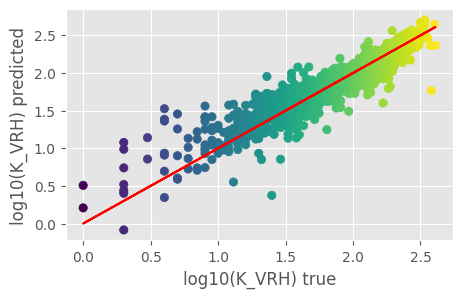

The training MAE = 0.099 log10GPa
The training RMSE = 0.148 log10GPa
The training r^2 = 0.860
The training MAE = 0.099 log10GPa
The training RMSE = 0.148 log10GPa
The training r^2 = 0.980
From our cross-validation, we have obtained the following results:
mean MAE = 0.096 log10GPa
mean r^2 = 0.849


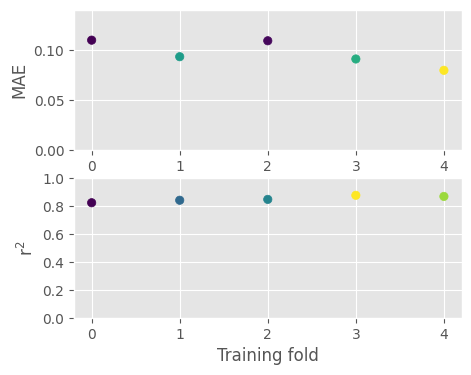

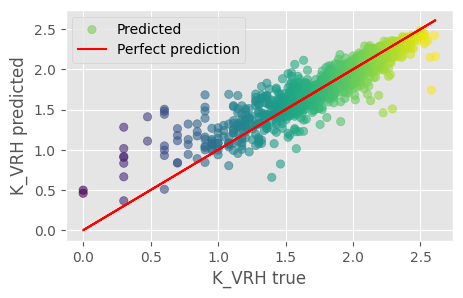

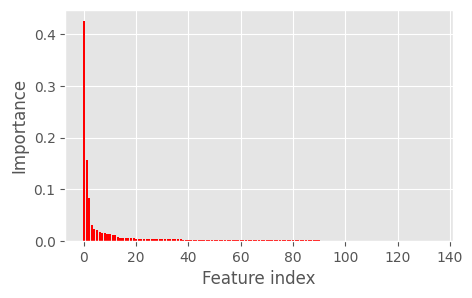

<ipython-input-5-db708e3c82c0>:221: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_feature_names, rotation=45, ha='right', rotation_mode='anchor')


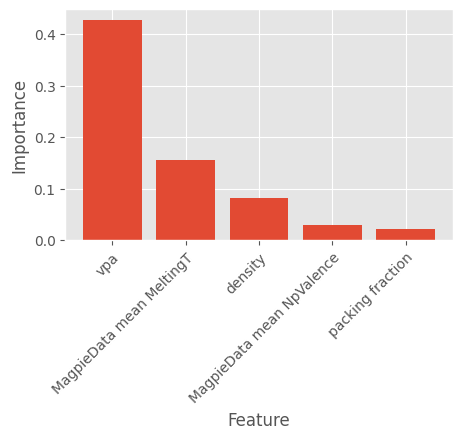

Top 5 Features:
    1. vpa (0.427)
    2. MagpieData mean MeltingT (0.156)
    3. density (0.083)
    4. MagpieData mean NpValence (0.030)
    5. packing fraction (0.022)


In [ ]:
# Basic utilities
import pprint  # Pretty print data structures
import warnings  # Warning control
import numpy as np # Numerical operations

# Data handling
import pandas as pd  # Data manipulation with DataFrames
from monty.serialization import loadfn  # Load serialised data

# Materials science
from pymatgen.core import Structure  # Materials analysis for crystal structures
import matminer  # Materials informatics
from matminer.datasets.dataset_retrieval import load_dataset  # Load materials datasets

# Visualisation
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Statistical visualisation
plt.style.use('ggplot')  # Set Matplotlib style to 'ggplot'

# Performance adjustments
teaching_mode = True  # To make models run faster

df = load_dataset('matbench_log_kvrh')
print(f'The full dataset contains {df.shape[0]} entries. \n')

if teaching_mode:
  # Store the original DataFrame as a copy
  full_dataset_df = df.copy()
  # Create a subset of the original DataFrame for demonstration purposes
  df = df.sample(n=1500, random_state=41)
  print(f'For teaching purposes we will only work with {df.shape[0]} entries from the DataFrame to make the model training and testing faster. \n')


from matminer.featurizers.composition.composite import ElementProperty
from matminer.featurizers.structure.order import DensityFeatures

# Add a composition column to df using the composition property of the Structure class and a lambda function
df['composition'] = df.structure.apply(lambda x: x.composition )

# Create the ElementProperty featuriser
el_prop_featuriser = ElementProperty.from_preset(preset_name='magpie')

# By default multiprocessing is enabled, however this has been known to slow performance on some systems, so we disable it
el_prop_featuriser.set_n_jobs(1)

# Apply the ElementProperty featuriser
df = el_prop_featuriser.featurize_dataframe(df, col_id='composition')

# Print the shape of the DataFrame
print(df.shape)
df.head()

# Crystal structure to vector
density_featuriser = DensityFeatures()
density_featuriser.set_n_jobs(1)
df=density_featuriser.fit_featurize_dataframe(df, col_id='structure')

df.head()

# Define the features we want to keep
features_to_drop = ['structure','composition','log10(K_VRH)']
feature_cols = [col for col in list(df.columns) if col not in features_to_drop]

# Get an array of the features
X = df[feature_cols].values

# Get an array of the target variable
y = df['log10(K_VRH)'].values

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

# Import linear regression model
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Fit the model to the data
lr = LinearRegression()
lr.fit(X, y)

def make_prediction_plot(X, y, model, label):
    """
    Plot and return predictions for the given model and data.

    Parameters:
    X : Input features.
    y : Actual target values.
    model : Fitted model.
    label : Descriptor for the axes labels.

    Returns:
    Predicted values.
    """
    y_pred = model.predict(X)
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.scatter(y, y_pred, c=y, cmap='viridis')
    ax.plot(y, y, 'r-')
    ax.set_xlabel(f'{label} true')
    ax.set_ylabel(f'{label} predicted')
    plt.show()

    return y_pred

# Make predictions using the fitted model
y_pred = make_prediction_plot(X, y, lr, 'log10(K_VRH)')

from sklearn import metrics

# Mean absolute error
print (f'The training MAE = {metrics.mean_absolute_error(y,y_pred):.3f} log10GPa')

# Mean squared error
print(f'The training RMSE = {metrics.root_mean_squared_error(y,y_pred):.3f} log10GPa')

# $r^2$ - coefficient of determination
print(f'The training r^2 = {lr.score(X,y):.3f}')

from sklearn.ensemble import RandomForestRegressor

# Define the model
rf = RandomForestRegressor(n_estimators=100,criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)

# Fit the model
rf.fit(X,y)

# Print the metrics
print(f'The training MAE = {metrics.mean_absolute_error(y,y_pred):.3f} log10GPa')
print(f'The training RMSE = {metrics.root_mean_squared_error(y,y_pred):.3f} log10GPa')
print(f'The training r^2 = {rf.score(X,y):.3f}')

from sklearn.model_selection import KFold, cross_val_score, cross_validate

# Define the number of splits for cross-validation
n_splits = 5 if teaching_mode else 10

# Compute the cross-validation score
cv = KFold(
    n_splits=n_splits,
    shuffle=True,
    random_state=42
    )

scores= cross_val_score(rf, X, y,cv=cv, scoring='neg_mean_absolute_error')

r2_scores = cross_val_score(rf, X, y, cv=cv, scoring='r2')

print('From our cross-validation, we have obtained the following results:')
print(f'mean MAE = {np.mean(np.abs(scores)):.3f} log10GPa')
print(f'mean r^2 = {np.mean(np.abs(r2_scores)):.3f}')

# Show the training scores for each k-fold
fig, ax = plt.subplots(2, 1, figsize=(5, 4))

ax[0].scatter([i for i in range(len(scores))], np.abs(scores), c=scores, cmap='viridis')
ax[1].scatter([i for i in range(len(r2_scores))], np.abs(r2_scores), c=r2_scores, cmap='viridis')
ax[0].set_xlabel('Training fold')
ax[0].set_ylabel('MAE')
ax[0].set_ylim(0, 0.14)
ax[0].set_xticks(range(len(scores)))
ax[1].set_xticks(range(len(r2_scores)))
ax[1].set_xlabel('Training fold')
ax[1].set_ylabel('r$^2$')
ax[1].set_ylim(0, 1.0)

# Display the plot
plt.show()

from sklearn.model_selection import cross_val_predict

# Plot the original and predicted data against each other
fig, ax = plt.subplots(figsize=(5, 3))

# Scatter plot with color
ax.scatter(y, cross_val_predict(rf, X, y, cv=cv), c=y, cmap='viridis', label='Predicted', alpha=0.6)

# Red line representing a perfect prediction (y = x)
ax.plot(y, y, 'r-', label='Perfect prediction')

# Set labels and legend
ax.set_xlabel('K_VRH true')
ax.set_ylabel('K_VRH predicted')
ax.legend()

plt.show()

# Get the feature importances
importances = rf.feature_importances_

# Get the indices that would sort the importances array from largest to smallest
indices = np.argsort(importances)[::-1]

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(5, 3))

# Create a bar plot of the feature importance
ax.bar(range(X.shape[1]), importances[indices], color="r", align="center")

# Set the labels
ax.set_xlabel("Feature index")
ax.set_ylabel("Importance")

plt.show()

# Visualise the top N features
N = 5

# Get the names of the top N important features
top_feature_names = df[feature_cols].columns.values[np.argsort(importances)[::-1][:N]]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(5, 3))

# Create a bar plot of the top N feature importances
ax.bar(x=top_feature_names, height=importances[np.argsort(importances)[::-1][:N]])

# Set the labels and title
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")

# Rotate x-axis labels for better readability
ax.set_xticklabels(top_feature_names, rotation=45, ha='right', rotation_mode='anchor')

plt.show()

# Print them too
print(f"Top {N} Features:")
for feat in range(N):
    print(f"    {feat+1}. {feature_cols[indices[feat]]} ({importances[indices[feat]]:.3f})")

In [ ]:
#CODING BLOCK





## Problem 2 --- thermoelectrics

Unsupervised machine learning techniques, such as dimensionality reduction, allow us to uncover patterns and relationships in complex datasets.

1.  Compare the clustering performance of PCA and t-SNE when applied to the Magpie feature set (using default parameters in 2D). State which method gives the best cluster separation with respect to zT value by visual inspection. Why do you think that is?

2. Experiment with different values of `perplexity` and `learning_rate`, which are two main hyperparamaters of t-SNE.  Perplexity is a smooth measure of the effective number of neighbours. If the learning rate is too low, the optimiser will likely get stuck.  The default values are `perplexity=30`, `learning_rate=200`. Comment on your findings


Fetching ucsb_thermoelectrics.json.gz from https://ndownloader.figshare.com/files/28333845 to /usr/local/lib/python3.11/dist-packages/matminer/datasets/ucsb_thermoelectrics.json.gz


Fetching https://ndownloader.figshare.com/files/28333845 in MB: 0.045056MB [00:00, 28.45MB/s]                 


Featurising compositions...


100%|██████████| 1093/1093 [00:04<00:00, 253.06it/s]


Computing feature vectors...


100%|██████████| 1093/1093 [00:00<00:00, 116201.31it/s]


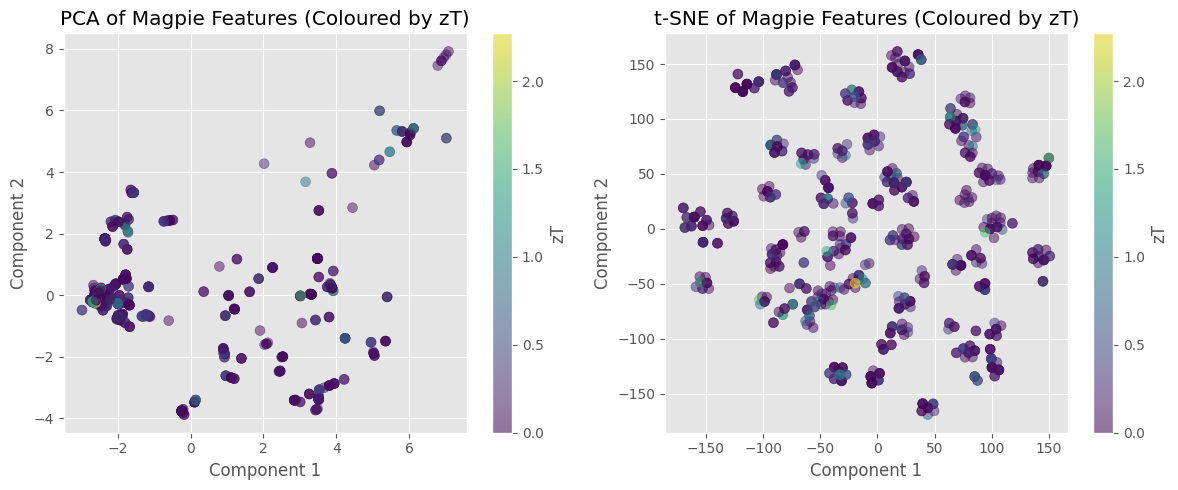

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint  # Pretty print data structures
import os  # Operating system functions
import seaborn as sns  # Visualisation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from elementembeddings.composition import composition_featuriser
import matminer  # Materials informatics
from matminer.datasets.dataset_retrieval import load_dataset  # Load materals datasets

# Load dataset
df = load_dataset('ucsb_thermoelectrics')

# Feature extraction
magpie_df = composition_featuriser(df, formula_column="composition", embedding='magpie')

# Extract target variable (zT) and features
zT_values = df["zT"].values  # Ensure zT is present
new_features_df = magpie_df.drop(columns=df.columns).dropna()

# Extract feature values
X = new_features_df.values
X_standardised = StandardScaler().fit_transform(X)

# Standardise features
scaler = StandardScaler()
X_standardised = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardised)

# Apply t-SNE (default parameters)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_standardised)

# Plot PCA and t-SNE
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# PCA Plot
sc1 = ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=zT_values, cmap='viridis', alpha=0.5, s=50)
ax[0].set_title("PCA of Magpie Features (Coloured by zT)")
ax[0].set_xlabel("Component 1")
ax[0].set_ylabel("Component 2")
plt.colorbar(sc1, ax=ax[0], label="zT")

# t-SNE Plot
sc2 = ax[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=zT_values, cmap='viridis', alpha=0.5, s=50)
ax[1].set_title("t-SNE of Magpie Features (Coloured by zT)")
ax[1].set_xlabel("Component 1")
ax[1].set_ylabel("Component 2")
plt.colorbar(sc2, ax=ax[1], label="zT")

plt.tight_layout()
plt.show()




In [ ]:
#Code section for investigating different values of perplexity and learning_rate



